Learns non-chaotic lorenz with $\rho(t)$ transitioning from 14 to 15.  

In [1]:
# Import the necessary packages:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

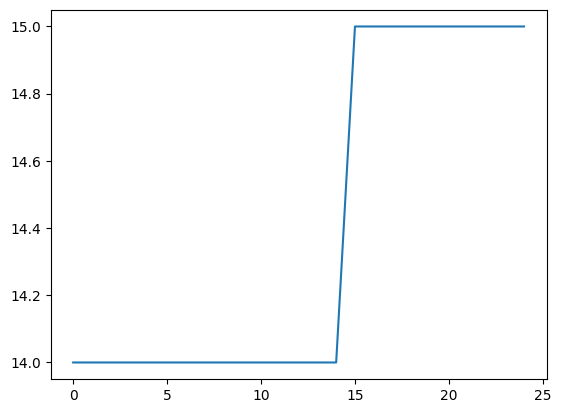

In [61]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [14.0, 15.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [213]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.01
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15), (15, 30)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(2, 1500, 2, 3)

### Normalizing Data

In [214]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [215]:
data_norm.shape

(2, 1500, 2, 3)

In [216]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [217]:
data_norm[0, :, 0, 0].shape

(1500,)

IndexError: index 2 is out of bounds for axis 0 with size 2

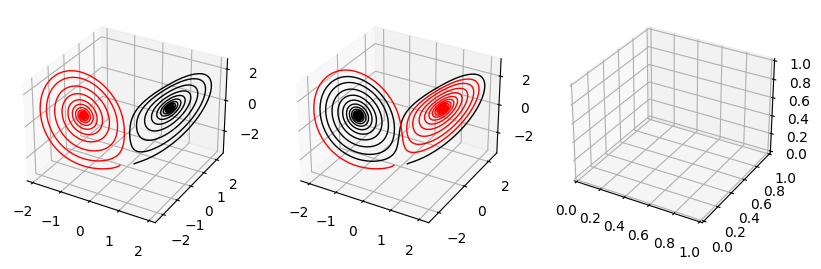

In [218]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   


ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot(xs=data_norm[1, :, 0, 0], ys=data_norm[1, :, 0, 1], zs=data_norm[1, :, 0, 2], color = 'black', linewidth = 1 )
ax2.plot(xs=data_norm[1, :, 1, 0], ys=data_norm[1, :, 1, 1], zs=data_norm[1, :, 1, 2], color = 'red', linewidth = 1)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot(xs=data_norm[2, :, 0, 0], ys=data_norm[2, :, 0, 1], zs=data_norm[2, :, 0, 2], color = 'black', linewidth = 1 )
ax3.plot(xs=data_norm[2, :, 1, 0], ys=data_norm[2, :, 1, 1], zs=data_norm[2, :, 1, 2], color = 'red', linewidth = 1)
#ax1.view_init(elev = 30, azim = 120)


# Training Neural ODE

In [219]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=2, width = 30, time_range=[0, 30], num_breakpoints=1, activation_func=nn.Tanh())

In [220]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [221]:
np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])

array([[0.000e+00, 1.000e-02, 2.000e-02, ..., 1.497e+01, 1.498e+01,
        1.499e+01],
       [1.500e+01, 1.501e+01, 1.502e+01, ..., 2.997e+01, 2.998e+01,
        2.999e+01]], shape=(2, 1500))

In [222]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([2, 1500])

## Single Loop 

In [223]:
training_data_tensor.shape

torch.Size([2, 1500, 2, 3])

In [224]:

t_eval_tensor.shape[1]

1500

In [225]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(2.0358, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.0040])



## Main Training Loop

In [226]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [229]:
batch_length = 25
num_batch = 40
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/1000 [00:19<5:17:34, 19.07s/it]

Epoch 0, Loss: 3.125459671020508


  2%|▏         | 21/1000 [09:03<9:01:27, 33.18s/it]

Epoch 20, Loss: 1.1075743436813354


  4%|▍         | 41/1000 [19:39<8:53:24, 33.37s/it]

Epoch 40, Loss: 0.8554652333259583


  6%|▌         | 61/1000 [31:02<8:32:44, 32.76s/it]

Epoch 60, Loss: 0.7888368964195251


  8%|▊         | 81/1000 [42:34<7:25:39, 29.10s/it]

Epoch 80, Loss: 0.8942493200302124


 10%|█         | 101/1000 [51:05<6:47:20, 27.19s/it]

Epoch 100, Loss: 0.8728222250938416


 12%|█▏        | 121/1000 [59:43<6:16:50, 25.72s/it]

Epoch 120, Loss: 0.9841580986976624


 14%|█▍        | 141/1000 [1:07:46<6:05:13, 25.51s/it]

Epoch 140, Loss: 0.8894640207290649


 16%|█▌        | 161/1000 [1:15:46<5:52:29, 25.21s/it]

Epoch 160, Loss: 0.8793011903762817


 18%|█▊        | 181/1000 [1:24:34<6:19:39, 27.81s/it]

Epoch 180, Loss: 0.8695633411407471


 20%|██        | 201/1000 [1:33:17<5:49:59, 26.28s/it]

Epoch 200, Loss: 0.8616335988044739


 22%|██▏       | 221/1000 [1:39:17<4:08:55, 19.17s/it]

Epoch 220, Loss: 0.8614622354507446


 24%|██▍       | 241/1000 [1:45:08<3:50:45, 18.24s/it]

Epoch 240, Loss: 0.8544232845306396


 26%|██▌       | 255/1000 [1:52:34<5:28:53, 26.49s/it]


KeyboardInterrupt: 

## Plotting results

Text(0.5, 0, 'Epochs')

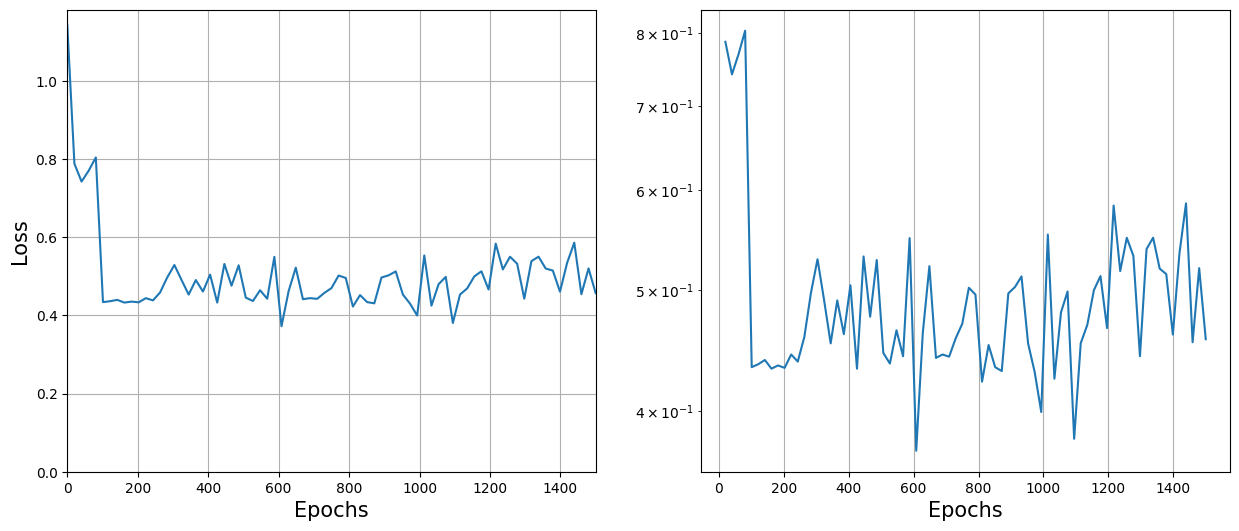

In [63]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [47]:
t_Start_pred = 0; t_Final_pred = 25
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

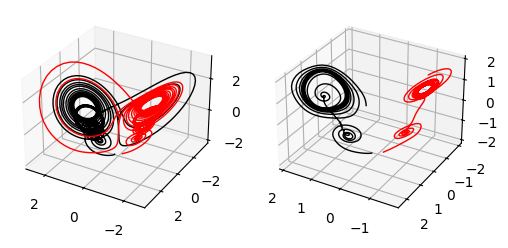

In [48]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[:, 0, 0], ys=training_data_tensor[:, 0, 1], zs=training_data_tensor[:, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[:, 1, 0], ys=training_data_tensor[:, 1, 1], zs=training_data_tensor[:, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [ ]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [ ]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 1, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[:index, 0, 0], ys=training_data_tensor[:index, 0, 1], zs=training_data_tensor[:index, 0, 2], color = 'black', linewidth = 1 )
        #ax1.plot(xs=training_data_tensor[:index, 1, 0], ys=training_data_tensor[:index, 1, 1], zs=training_data_tensor[:index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        #ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        #ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        #ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        #ax2.view_init(elev = 30, azim = 120)



In [61]:

interact(plot_interact2, index=IntSlider(min=0, max=2500, step=10))

interactive(children=(IntSlider(value=0, description='index', max=2500, step=10), Output()), _dom_classes=('wi…

<function __main__.plot_interact2(index)>

In [ ]:
training_data_tensor[:, 0, :]

tensor([[ 0.1419,  0.1330, -2.0890],
        [-0.1419, -0.1330, -2.0890]], dtype=torch.float64)

In [ ]:
training_data_tensor[:, 0, :]

tensor([[ 0.1419,  0.1330, -2.0890],
        [-0.1419, -0.1330, -2.0890]], dtype=torch.float64)

## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
